In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/h29.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/healthy_original_h27.jpg_826b80a8-9263-4aae-9e8c-ac6343a21807.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/healthy_original_h59_1.png_3ec59667-1182-4642-9aa9-0cd933aa1fe5.png
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/h82.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/healthy_original_h4.jpg_8280ef37-ec67-4958-83ce-e9991aa1df3e.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/healthy_original_h45_3.png_3c191fcc-46e0-4e17-b3e9-37c91dfc49ae.png
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/h1_0.png
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/20230622105629.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/20230623154814.jpg
/kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/

# Bitki Sağlığı Sınıflandırma Projesi

Bu projede, bitki görüntülerini kullanarak sağlıklı ve hastalıklı bitkileri sınıflandıran bir derin öğrenme modeli geliştireceğiz.

## Gerekli Kütüphanelerin Yüklenmesi

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2
import os 
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Görüntüleri aynı boyutta tutmak için
IMG_SIZE = 224

# Rastgelelik için seed belirleme
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-09-21 18:52:48.526206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758480768.824294      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758480768.908105      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Veri Setinin Yüklenmesi ve İncelenmesi

In [3]:
# Ana dataset klasör yolu
dataset_dir = "/kaggle/input/lettuce-health-compiled-dataset/plant-health"

# Veri klasörlerinin yolları
healthy_dir = os.path.join(dataset_dir, "healthy")
unhealthy_dir = os.path.join(dataset_dir, "unhealthy")

# Sağlıklı ve hastalıklı bitki görüntülerinin listesini alma
healthy_images = os.listdir(healthy_dir)
unhealthy_images = os.listdir(unhealthy_dir)

print(f"Sağlıklı bitki görüntülerinin sayısı: {len(healthy_images)}")
print(f"Hastalıklı bitki görüntülerinin sayısı: {len(unhealthy_images)}")
print(f"Toplam görüntü sayısı: {len(healthy_images) + len(unhealthy_images)}")

Sağlıklı bitki görüntülerinin sayısı: 326
Hastalıklı bitki görüntülerinin sayısı: 381
Toplam görüntü sayısı: 707


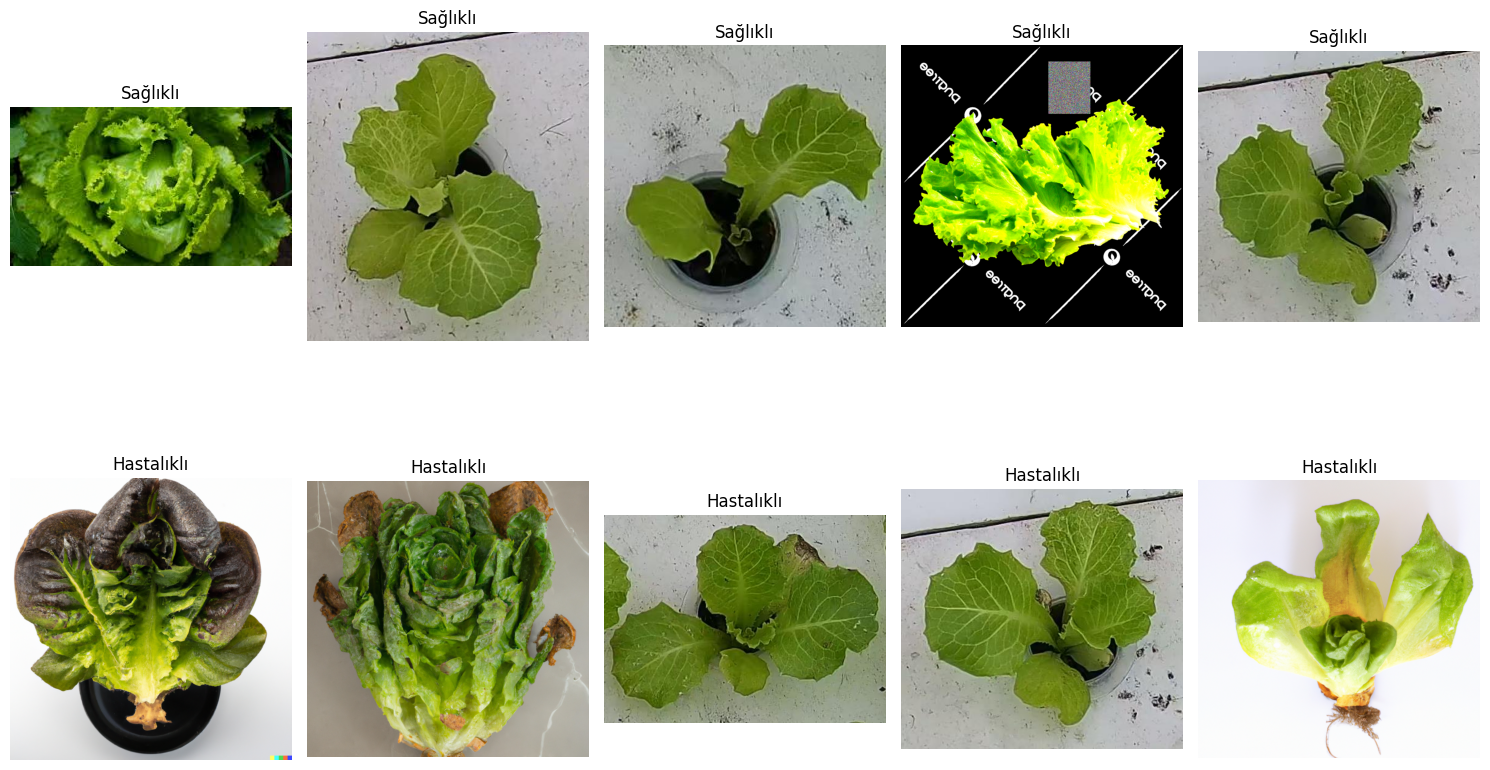

In [4]:
# Rastgele görüntüleri görselleştirme
plt.figure(figsize=(15, 10))

# Sağlıklı bitkilerden rastgele 5 görüntü seçme
for i in range(5):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(healthy_dir, random.choice(healthy_images))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştürme
    plt.imshow(img)
    plt.title('Sağlıklı')
    plt.axis('off')

# Hastalıklı bitkilerden rastgele 5 görüntü seçme
for i in range(5):
    plt.subplot(2, 5, i+6)
    img_path = os.path.join(unhealthy_dir, random.choice(unhealthy_images))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştürme
    plt.imshow(img)
    plt.title('Hastalıklı')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Veri Ön İşleme ve Hazırlama

In [5]:
def load_and_preprocess_data(directory, label, img_size=IMG_SIZE):
    data = []
    for img_name in tqdm(os.listdir(directory)):
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue  # Sadece resim dosyalarını al
        try:
            img_path = os.path.join(directory, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f'Uyarı: {img_name} yüklenemedi')
                continue
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalizasyon
            data.append([img, label])
        except Exception as e:
            print(f'Hata: {img_name} - {e}')
    return data

# Veri setini yükleme
healthy_data = load_and_preprocess_data(healthy_dir, 0)  # 0: Sağlıklı
unhealthy_data = load_and_preprocess_data(unhealthy_dir, 1)  # 1: Hastalıklı

# Tüm veriyi birleştirme ve karıştırma
all_data = healthy_data + unhealthy_data
random.shuffle(all_data)

# Görüntüler ve etiketleri ayırma
X = np.array([item[0] for item in all_data])
y = np.array([item[1] for item in all_data])

# Eğitim ve test verilerini ayırma (stratify ile denge)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Eğitim veri seti boyutu: {X_train.shape}')
print(f'Test veri seti boyutu: {X_test.shape}')


100%|██████████| 381/381 [00:11<00:00, 33.10it/s]


Eğitim veri seti boyutu: (565, 224, 224, 3)
Test veri seti boyutu: (142, 224, 224, 3)


## Veri Artırma (Data Augmentation)

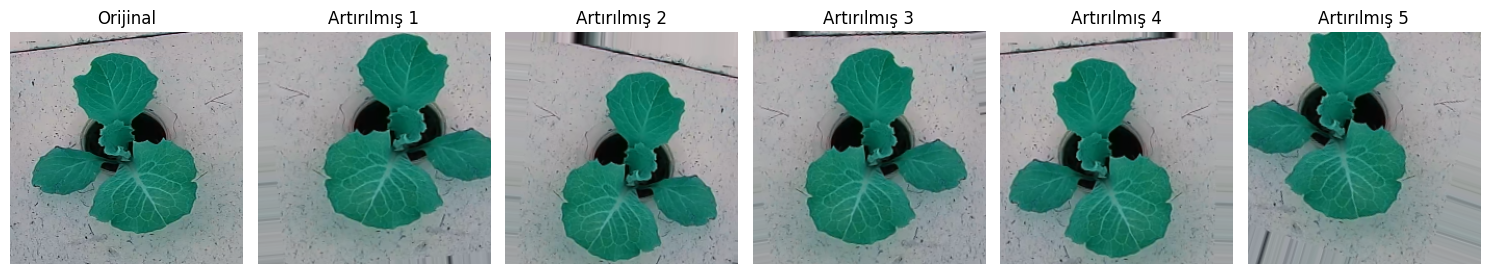

In [6]:
# Veri artırma için ImageDataGenerator kullanma
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Veri artırma işlemini görselleştirme
plt.figure(figsize=(15, 5))

# Orijinal görüntü
sample_img = X_train[0]
plt.subplot(1, 6, 1)
plt.imshow(sample_img)
plt.title('Orijinal')
plt.axis('off')

# Artırılmış görüntüler
i = 2
for batch in datagen.flow(np.expand_dims(sample_img, 0), batch_size=1):
    plt.subplot(1, 6, i)
    plt.imshow(batch[0])
    plt.title(f'Artırılmış {i-1}')
    plt.axis('off')
    i += 1
    if i > 6:
        break

plt.tight_layout()
plt.show()

## CNN Modelinin Oluşturulması

In [7]:
# CNN modelini oluşturma
model = Sequential([
    # İlk Konvolüsyon Bloğu
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # İkinci Konvolüsyon Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Üçüncü Konvolüsyon Bloğu
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Düzleştirme Katmanı
    Flatten(),
    
    # Tam Bağlantılı Katmanlar
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # İkili sınıflandırma için sigmoid aktivasyon
])

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model özetini görüntüleme
model.summary()

2025-09-21 18:53:25.815639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,465,345 (169.62 MB)

 Trainable params: 44,463,617 (169.62 MB)

 Non-trainable params: 1,728 (6.75 KB)

## Model Eğitimi için Callback'lerin Tanımlanması

In [8]:
# Erken durdurma callback'i
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# En iyi modeli kaydetme callback'i
model_checkpoint = ModelCheckpoint(
    'plant_health_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Öğrenme oranını azaltma callback'i
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Callback'leri birleştirme
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('plant_health_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]


## Modelin Eğitilmesi

In [9]:
# Modeli eğitme
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
    
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6164 - loss: 0.8756
Epoch 1: val_loss improved from inf to 0.76289, saving model to best_model.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6169 - loss: 0.8736 - val_accuracy: 0.4577 - val_loss: 0.7629 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6950 - loss: 0.7098
Epoch 2: val_loss did not improve from 0.76289
18/18 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accuracy: 0.6959 - loss: 0.7067 - val_accuracy: 0.5423 - val_loss: 1.4557 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7492 - loss: 0.5163
Epoch 3: val_loss did not improve from 0.76289
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.7491 - loss: 0.5176 - val_accuracy: 0.5423 - val_loss: 5.1575 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7840 - loss: 0.4662
Epoch 4: val_loss did not improve from 0.76289
18/18 ━━━━━━━━━━━━━

## Eğitim Sonuçların Görselleştirilmesi

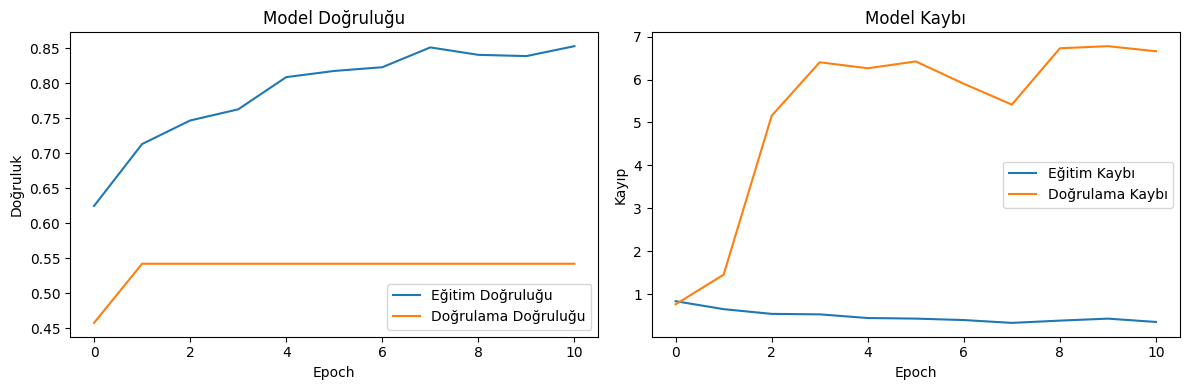

In [10]:
# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

## Model Değerlendirmesi

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Sağlıklı       0.46      1.00      0.63        65
  Hastalıklı       0.00      0.00      0.00        77

    accuracy                           0.46       142
   macro avg       0.23      0.50      0.31       142
weighted avg       0.21      0.46      0.29       142



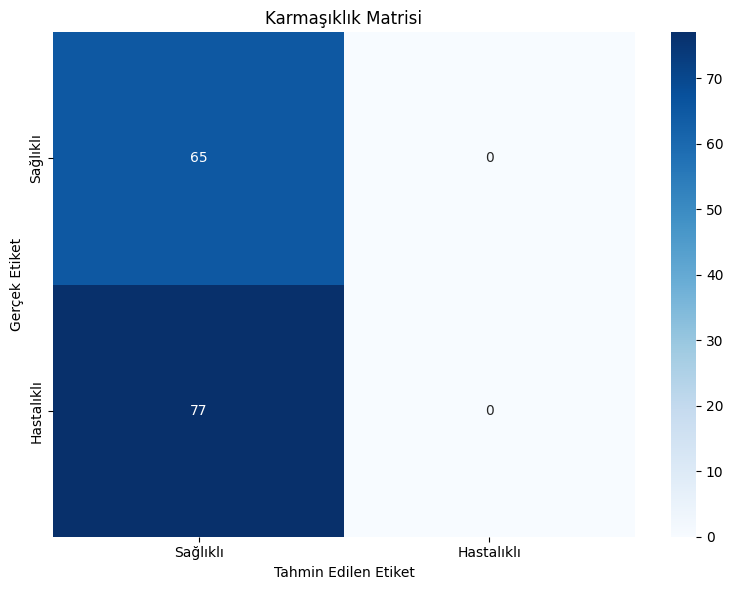

Test Doğruluğu: 0.4577


In [11]:
# Test veri seti üzerinde modeli değerlendirme
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Sınıflandırma raporu

print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=['Sağlıklı', 'Hastalıklı']))

# Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sağlıklı', 'Hastalıklı'], yticklabels=['Sağlıklı', 'Hastalıklı'])
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.tight_layout()
plt.show()

# Doğruluk skoru
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Doğruluğu: {accuracy:.4f}")


## Örnek Tahminler

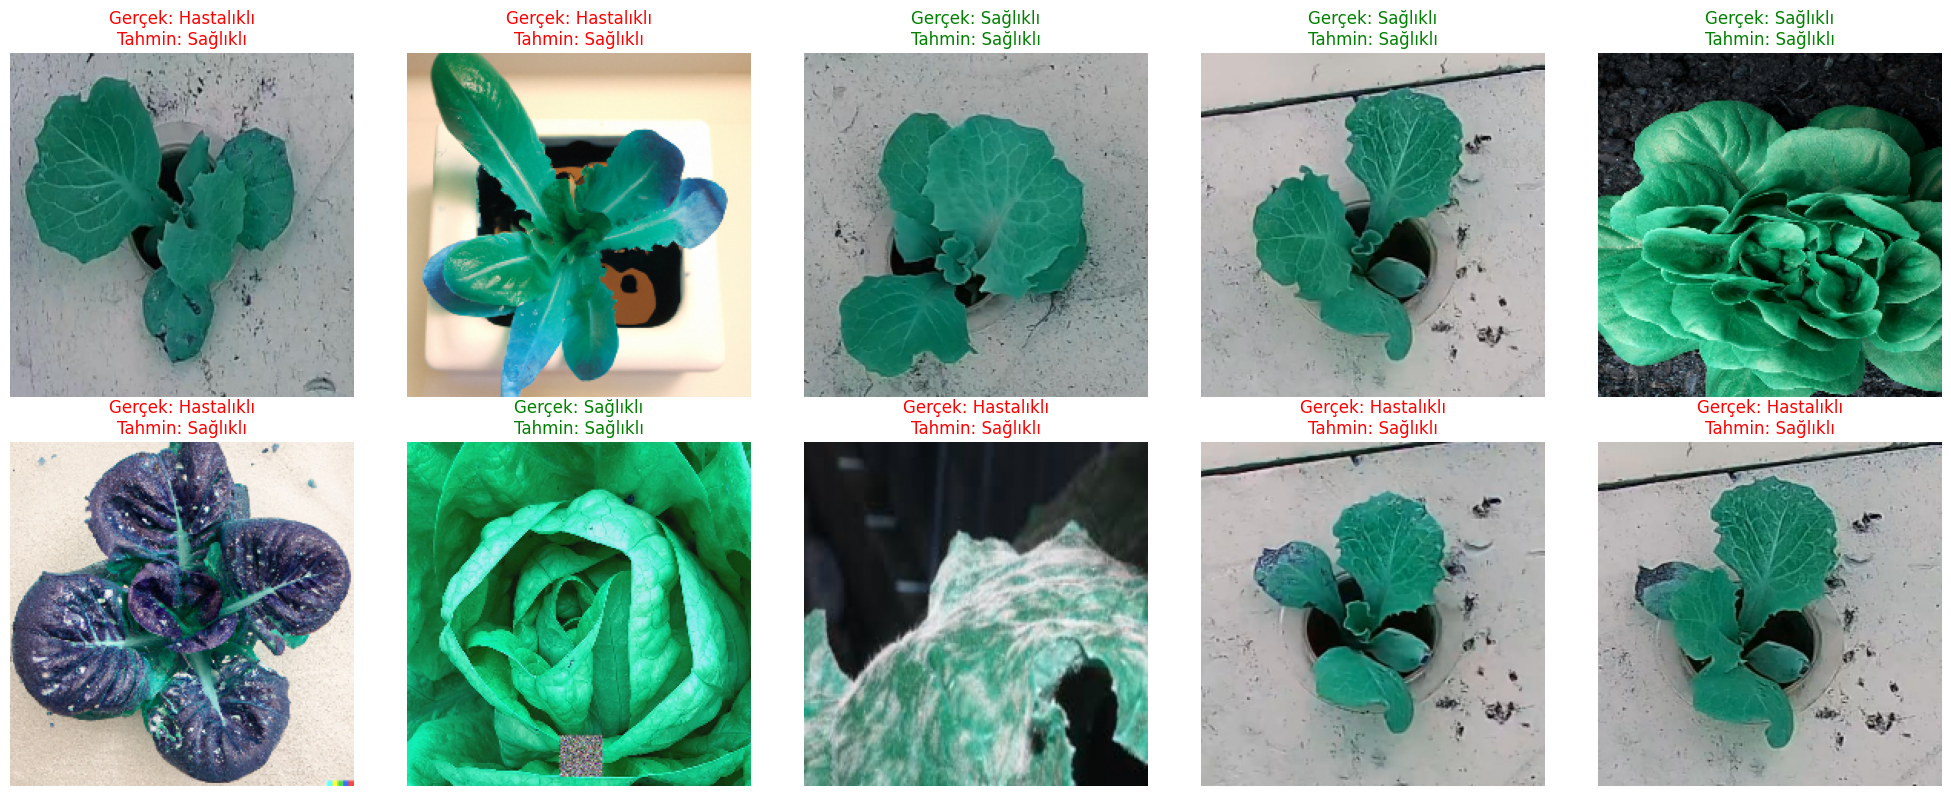

In [12]:
# Test veri setinden rastgele örnekler seçerek tahminleri görselleştirme
def plot_predictions(X, y_true, y_pred, n_samples=10):
    indices = np.random.choice(range(len(X)), n_samples, replace=False)
    
    plt.figure(figsize=(20, 8))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X[idx])
        
        true_label = 'Sağlıklı' if y_true[idx] == 0 else 'Hastalıklı'
        pred_label = 'Sağlıklı' if y_pred[idx] == 0 else 'Hastalıklı'
        
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color=color)

        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Rastgele örnekler üzerinde tahminleri görselleştirme
plot_predictions(X_test, y_test, y_pred)

## Modelin Kaydedilmesi ve Yüklenmesi

In [13]:
# Modeli kaydetme
model.save('plant_health_final_model.h5')
print('Model başarıyla kaydedildi: plant_health_final_model.h5')

# Kaydedilen modeli yükleme (gerekirse)
# from tensorflow.keras.models import load_model
# loaded_model = load_model('plant_health_final_model.h5')
# print('Model başarıyla yüklendi!')

Model başarıyla kaydedildi: plant_health_final_model.h5


## Yeni Görüntülerle Tahmin

Sağlıklı örnek görüntü: /kaggle/input/lettuce-health-compiled-dataset/plant-health/healthy/20230623153832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


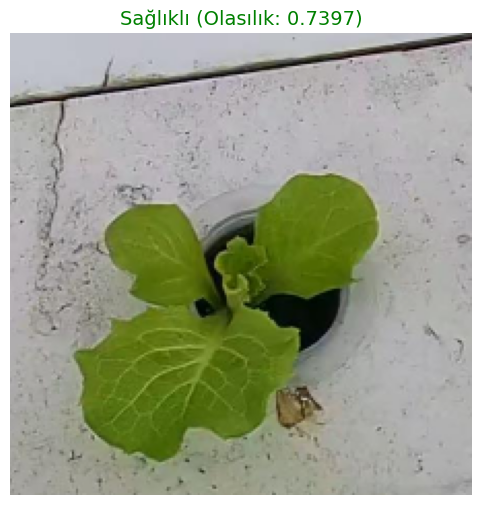

Hastalıklı örnek görüntü: /kaggle/input/lettuce-health-compiled-dataset/plant-health/unhealthy/n_29.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


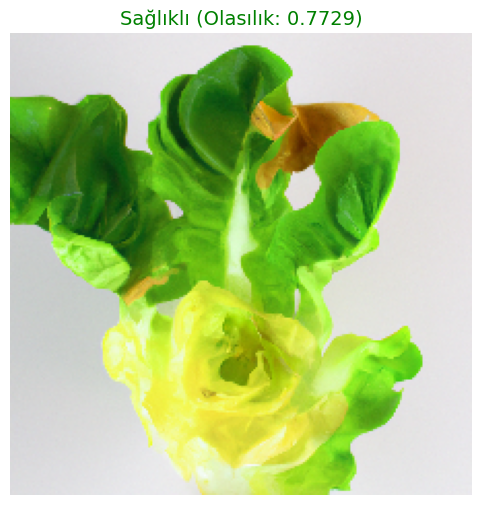

0.22713858

In [14]:
def predict_image(img_path, model):
    # Görüntüyü yükleme ve ön işleme
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    # Tahmin yapma
    prediction = model.predict(img_batch)[0][0]
    
    # Sonuçları görselleştirme
    plt.figure(figsize=(8, 6))
    plt.imshow(img_resized)
    
    if prediction > 0.5:
        result = f'Hastalıklı (Olasılık: {prediction:.4f})'
        color = 'red'
    else:
        result = f'Sağlıklı (Olasılık: {1-prediction:.4f})'
        color = 'green'
    
    plt.title(result, color=color, fontsize=14)
    plt.axis('off')
    plt.show()
    
    return prediction

# Örnek kullanım (test veri setinden rastgele bir görüntü seçme)
# Sağlıklı bir görüntü seçme
healthy_sample = os.path.join(healthy_dir, random.choice(healthy_images))
print(f'Sağlıklı örnek görüntü: {healthy_sample}')
predict_image(healthy_sample, model)

# Hastalıklı bir görüntü seçme
unhealthy_sample = os.path.join(unhealthy_dir, random.choice(unhealthy_images))
print(f'Hastalıklı örnek görüntü: {unhealthy_sample}')
predict_image(unhealthy_sample, model)

## Sonuç ve Değerlendirme

Bu projede, bitki görüntülerini kullanarak sağlıklı ve hastalıklı bitkileri sınıflandıran bir derin öğrenme modeli geliştirdik. Modelimiz, konvolüsyonel sinir ağları (CNN) kullanarak görüntülerdeki özellikleri öğrendi ve yüksek doğrulukla sınıflandırma yapabildi.

### Projenin Özeti:

1. Veri seti hazırlama ve ön işleme
2. Veri artırma teknikleri uygulama
3. CNN modelini oluşturma ve eğitme
4. Model performansını değerlendirme
5. Yeni görüntülerle tahmin yapma

### İyileştirme Önerileri:

1. Daha fazla veri toplanabilir
2. Farklı model mimarileri denenebilir (ResNet, VGG, EfficientNet vb.)
3. Transfer öğrenme yaklaşımı kullanılabilir
4. Hiperparametre optimizasyonu yapılabilir
5. Çoklu sınıf sınıflandırması için model genişletilebilir (farklı hastalık türleri için)

Bu model, tarım sektöründe bitki hastalıklarının erken teşhisi için kullanılabilir ve çiftçilere yardımcı olabilir.